# Hyperparameters and Model Validation

Basic recipe for applying a supervised machine learning model:
1. Choose a class of model
2. Choose model hyperparameters
3. Fit the model to the training data
4. Use the model to predict labels for new data

The first two pieces of this- the choice of model and choice of hyperparameters - are perhaps the most important part of using these tools and techniques effectively. In order to make an informed choice, we need a way to _validate_ to our model and our hyperparameters are a good fit to the data. While this may sound simple, there are some pitfalls that you must avoid to do this effectively.

## Thinking about Model Validation

In principle, model validation is very simple: after choosing a model and its hyperparameters, we can estimate how effective it is by applying it to some of the training data and comparing the prediction to the known value.

The following sections first show a naive approach to model validation and why it fails, before exploring the use of holdout sets and cross-validation for more robust model evaluation.

## Model validation the wrong way

Let's demonstrate the naive approach to validation using the Iris data, which we saw in the previous section. We will start by loading the data:

In [1]:
from sklearn.datasets import load_iris
iris = load_iris()
X = iris.data
y = iris.target

Next we choose a model and hyperparameters. Here we'll use a _k-neighbors_ classifier with `n_neighbors=1`. This is a very simple and intutive model that says "the label of an unknown point is the same as the label of its closest training point:"

In [2]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=1)

Then we train the model, and use it to predict labels for data we already know:

In [3]:
model.fit(X, y)
y_model = model.predict(X)

Finally, we compute the fraction of correctly labeled points:

In [4]:
from sklearn.metrics import accuracy_score 
accuracy_score(y, y_model)

1.0



We see an accuracy score of 1.0, which indicates that 100% of points were correctly labeled by our model! But is this truly measuring the expected accuracy? Have we really come upon a model that we expect to be correct 100% of the time?

As you may have gathered, the answer is no. In fact, this approach contains a fundamental flaw: it trains and evaluates the model on the same data. Furthermore, the nearest neighbor model is an instance-based estimator that simply stores the training data, and predicts labels by comparing new data to these stored points: except in contrived cases, it will get 100% accuracy every time!


## Model validation the right way: Holdout sets

So what can be done? A better sense of a model's performance can be found using what's known as a _holdout set_: that is, we hold back some subset of the data from the training of the model, and then use this holdout set to check the model preformance. This splitting can be done using the `train_test_split` utility in Scikit-Learn:

In [5]:
from sklearn.model_selection import train_test_split
# split the data with 50% in each set
X1, X2, y1, y2 = train_test_split(X, y, random_state=0,
                                 train_size=0.5)

# fit the model on one set of data
model.fit(X1, y1)

# evaluate the model on the second set of data
y2_model = model.predict(X2)
accuracy_score(y2, y2_model)

/home/bksahu/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


0.9066666666666666

We see here a more resonable result: the nearest-neighbor classifier is about 90% accurate on this hold-out set. The hold-out set is similar to unkown data, because the model has not "seen" it before.

## Model validation via cross-validation

One disadvantage of using a holdout set for model validation is that we have lost a portion of our data to the model training. In the above case, half the dataset does not contribute to the training of the model! This is not optimal, and can cause problems – especially if the initial set of training data is small.

One way to address this is to use cross-validation; that is, to do a sequence of fits where each subset of the data is used both as a training set and as a validation set. Visually, it might look something like this:

Here we do two validation trails, alternately using each half of the data as a holdout set. Using the split data from before, we could implement it like this:

In [6]:
y2_model = model.fit(X1, y1).predict(X2)
y1_model = model.fit(X2, y2).predict(X1)
accuracy_score(y1, y1_model), accuracy_score(y2, y2_model)

(0.96, 0.9066666666666666)

What comes out are two accuracy scores, which we could combine (by, say, taking the mean) to get a better measure of the global model performance. This particular form of _cross-validation_ is a _two-fold cross-validation_—that is, one in which we have split the data into two sets and used each in turn as a validation set.

Here we split the data into five groups, and use each of them in turn to evaluate the model fit on the other 4/5 of the data. This would be rather tedious to do by hand, and so we can use Scikit-Learn's `cross_val_score` convenience routine to do it succinctly:

In [28]:
from sklearn.model_selection import cross_val_score
cross_val_score(model, X, y, cv=5)

array([0.95592906, 0.88066005, 0.77880442, 0.9654037 , 0.90180996])

Repeating the validation across different subsets of the data gives us an even better idea of the performance of the algorithm.

Scikit-Learn implements a number of useful cross-validation schemes that are useful in particular situations; thses are implemented via iterators in the `cross_validation` module. For example, we might wish to go to the extreme case in which our number of folds is equal to the number of data points: that is, we train on all points but one in each trail. This type of cross-validation is known as _leave-one-out_ cross validation, and can be used as follows:

In [8]:
from sklearn.cross_validation import LeaveOneOut
scores = cross_val_score(model, X, y, cv=LeaveOneOut(len(X)))
scores

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

Because we have 150 samples, the leave one out cross-validation yields scores for 150 trials, and **the score indicates either successful (1.0) or unsuccessful (0.0) prediction**. Taking the mean of these gives an estimate of the error rate:

In [9]:
scores.mean()

0.96

## Validation curves in Scikit-Learn

Let's look at an example of using cross-validation to compute the validation curve for a class of models. Here we will use a _polynomial regression model_. We can implement this with a simple linear regression combined with the polynomial preprocessor. We will use a _pipeline_ to string these operations together.

In [10]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree),
                        LinearRegression(**kwargs))

In [11]:
import numpy as np

def make_data(N, err=1.0, rseed=1):
    # randomly sample the data
    rng = np.random.RandomState(rseed)
    X = rng.rand(N, 1) ** 2
    y = 10 - 1. / (X.ravel() + 0.1)
    if err > 0:
        y += err * rng.randn(N)
    return X, y

X, y = make_data(40)

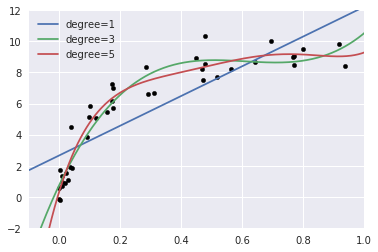

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn; seaborn.set()  # plot formatting

X_test = np.linspace(-0.1, 1.1, 500)[:, None]

plt.scatter(X.ravel(), y, color="black", s=20)
axis = plt.axis()
for degree in [1, 3, 5]:
    y_test = PolynomialRegression(degree).fit(X, y).predict(X_test)
    plt.plot(X_test.ravel(), y_test, label='degree={0}'.format(degree))
plt.xlim(-0.1, 1.0)
plt.ylim(-2, 12)
plt.legend(loc='best');    

We can make progress in this by visualizing the validation curve for this particular data and model; this can be done straightforwardly using the `validation_curve` convenience routine provided by Scikit-Learn. Given a model, data, parameter name, and a range to explore, this function will automatically compute both the training score and validation score across the range:

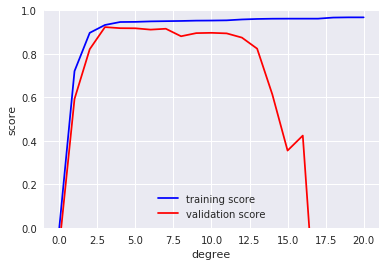

In [13]:
from sklearn.model_selection import validation_curve
degree = np.arange(0, 21)
train_score, val_score = validation_curve(PolynomialRegression(), X, y,
                                          'polynomialfeatures__degree', degree, cv=7)

plt.plot(degree, np.median(train_score, 1), color='blue', label='training score')
plt.plot(degree, np.median(val_score, 1), color='red', label='validation score')
plt.legend(loc='best')
plt.ylim(0, 1)
plt.xlabel('degree')
plt.ylabel('score');

score is everywhere higher than the validation score; the training score is monotonically improving with increased model complexity; and the validation score reaches a maximum before dropping off as the model becomes over-fit.

From the validation curve, we can read-off that the optimal trade-off between bias and variance is found for a third-order polynomial; we can compute and display this fit over the original data as follows:

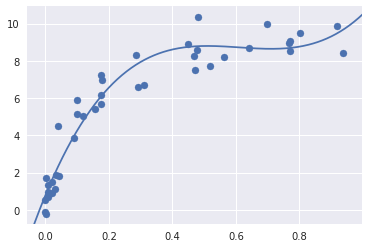

In [14]:
plt.scatter(X.ravel(), y)
lim = plt.axis()
y_test = PolynomialRegression(3).fit(X, y).predict(X_test)
plt.plot(X_test.ravel(), y_test);
plt.axis(lim);

Notice that finding this optimal model did not actually require us to compute the training score, but examining the relationship between the training score and validation score can give us useful insight into the performance of the model.

## Learning Curves

One important aspect of model complexity is that the optimal model will generally depend on the size of your training data. For example, let's generate a new dataset with a factor of five more points:


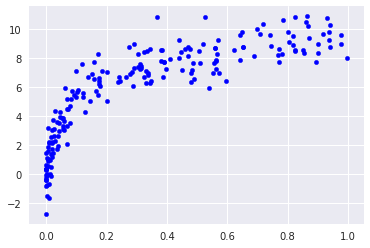

In [15]:
X2, y2 = make_data(200)
plt.scatter(X2.ravel(), y2, s=20, color='blue');

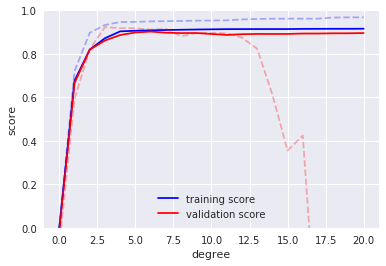

In [16]:
degree = np.arange(21)
train_score2, val_score2 = validation_curve(PolynomialRegression(), X2, y2,
                                            'polynomialfeatures__degree', degree, cv=7)

plt.plot(degree, np.median(train_score2, 1), color='blue', label='training score')
plt.plot(degree, np.median(val_score2, 1), color='red', label='validation score')
plt.plot(degree, np.median(train_score, 1), color='blue', alpha=0.3, linestyle='dashed')
plt.plot(degree, np.median(val_score, 1), color='red', alpha=0.3, linestyle='dashed')
plt.legend(loc='lower center')
plt.ylim(0, 1)
plt.xlabel('degree')
plt.ylabel('score');

The solid lines show the new results, while the fainter dashed lines show the results of the previous smaller dataset. It is clear from the validation curve that the larger dataset can support a much more complicated model: the peak here is probably around a degree of 6, but even a degree-20 model is not seriously over-fitting the data—the validation and training scores remain very close.

Thus we see that the behavior of the validation curve has not one but two important inputs: the model complexity and the number of training points. It is often useful to to explore the behavior of the model as a function of the number of training points, which we can do by using increasingly larger subsets of the data to fit our model. A plot of the training/validation score with respect to the size of the training set is known as a _learning curve_.

## Learning curves in Scikit-Learn

Scikit-Learn offers a convenient utility for computing such learning curves from your models; here we will compute a learning curve for our original dataset with a second-order polynomial model and a ninth-order polynomial:


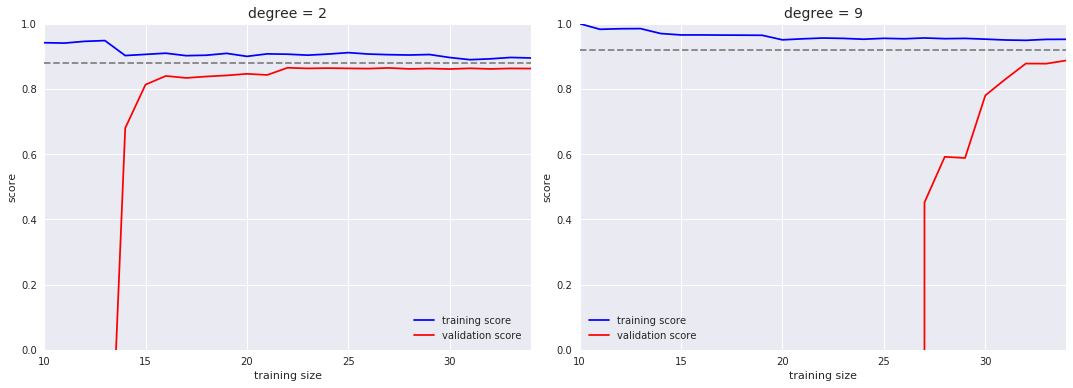

In [27]:
from sklearn.model_selection import learning_curve

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

for i, degree in enumerate([2, 9]):
    N, train_lc, val_lc = learning_curve(PolynomialRegression(degree),
                                         X, y, cv=7,
                                         train_sizes=np.linspace(0.3, 1, 25))

    ax[i].plot(N, np.mean(train_lc, 1), color='blue', label='training score')
    ax[i].plot(N, np.mean(val_lc, 1), color='red', label='validation score')
    ax[i].hlines(np.mean([train_lc[-1], val_lc[-1]]), N[0], N[-1],
                 color='gray', linestyle='dashed')

    ax[i].set_ylim(0, 1)
    ax[i].set_xlim(N[0], N[-1])
    ax[i].set_xlabel('training size')
    ax[i].set_ylabel('score')
    ax[i].set_title('degree = {0}'.format(degree), size=14)
    ax[i].legend(loc='best')

This is a valuable diagnostic, because it gives us a visual depiction of how our model responds to increasing training data. In particular, when your learning curve has already converged (i.e., when the training and validation curves are already close to each other) **adding more training data will not significantly improve the fit!** This situation is seen in the left panel, with the learning curve for the degree-2 model.

The only way to increase the converged score is to use a different (usually more complicated) model. We see this in the right panel: by moving to a much more complicated model, we increase the score of convergence (indicated by the dashed line), but at the expense of higher model variance (indicated by the difference between the training and validation scores). If we were to add even more data points, the learning curve for the more complicated model would eventually converge.

## Validation in Practice: Grid Search

The preceding discussion is meant to give you some intuition into the trade-off between bias and variance, and its dependence on model complexity and training set size. In practice, models generally have more than one knob to turn, and thus plots of validation and learning curves change from lines to multi-dimensional surfaces. In these cases, such visualizations are difficult and we would rather simply find the particular model that maximizes the validation score.

Scikit-Learn provides automated tools to do this in the grid search module. Here is an example of using grid search to find the optimal polynomial model. We will explore a three-dimensional grid of model features; namely the polynomial degree, the flag telling us whether to fit the intercept, and the flag telling us whether to normalize the problem. This can be set up using Scikit-Learn's `GridSearchCV` meta-estimator:


In [26]:
from sklearn.model_selection import GridSearchCV

param_grid = {'polynomialfeatures__degree': np.arange(21),
              'linearregression__fit_intercept': [True, False],
              'linearregression__normalize': [True, False]}

grid = GridSearchCV(PolynomialRegression(), param_grid, cv=7)

In [19]:
grid.fit(X, y);

In [20]:
# list best params
grid.best_params_

{'linearregression__fit_intercept': False,
 'linearregression__normalize': True,
 'polynomialfeatures__degree': 4}

Finally, if we wish, we can use the best model and show the fit to our data using code from below:

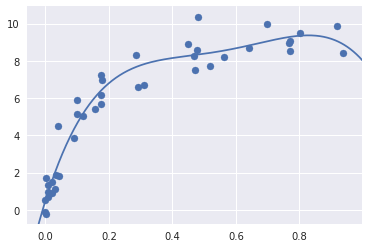

In [25]:
model = grid.best_estimator_

plt.scatter(X.ravel(), y)
lim = plt.axis()
y_test = model.fit(X, y).predict(X_test)
plt.plot(X_test.ravel(), y_test);
plt.axis(lim);